# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [59]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything

# Plotting style
%matplotlib ipympl

### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

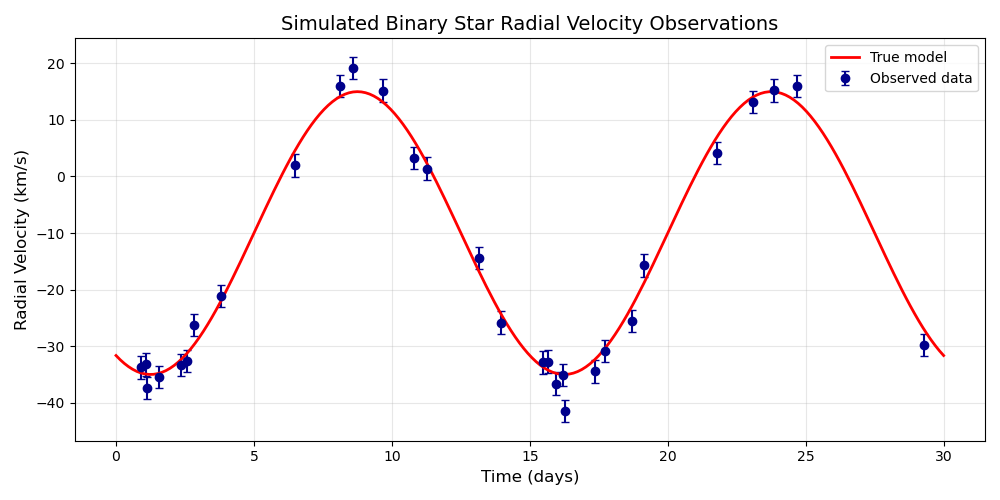

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = -10.0 km/s


In [74]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = -10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [230]:
def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    Remember
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    # you're doing this
    residuals = (v - radial_velocity_model(t, *theta)) / v_err
    return -0.5 * np.sum(residuals**2)

def log_prior(theta):
    """
    Returns -inf if parameters are outside allowed ranges.
    """
    # you're doing this
    K = theta[0]
    P = theta[1]
    t0 = theta[2]
    v0 = theta[3]

    if (K < 0 or K > 100) or\
        (P < 0.1 or P > 200)  or\
        (t0 < 0 or  t0 > P):   
        return -np.inf
    return 0.0

def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.

    """
    # you're doing this
    return log_prior(theta) + log_likelihood(theta, t, v, v_err)

#### Justify the choice of prior in a few sentences

K: K_true was 25 so i thought x4 would be a good limit to put. Also the amplitude is always non-negative.
P: our period here is around 15 days. I googled realistic period for binary stars and the numbers seemed pretty high. Alpha centari takes 80 year around its star. Since, i am the experimenter i want to keep it simple so i thought 200 was a decent limit. 0.1 is taken to avoid zero since 0 period makes no sense.
t0: since this is a sin wave, if we cross P. it becomes a shift in sin wave of P which is our origin sin wave. So it makes sense to keep it within P.
v0: can be anything so i took a flat prior.

#### Describe how you treated the uncertainties in a few sentences

I am dividing difference between model and data by the v_err (uncertainty) to obtain my chi-squared value. 




#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [244]:
# MCMC setup
ndim = 4
nwalkers = 20
nsteps = 10000

# Set some initial positions for the walkers - I'd suggest adding small random scatter around a guess
# you can get your guess from scipy.optimize or just making something up.

guess = np.array([20, 10, 5, -5])  #took it close to our true values
scatter = np.array([0.07, 0.7, 2.7, 1.7]) # some random scatter which i will multiply

scattered_guess = guess + np.random.randn(nwalkers, ndim) * scatter


#### Run the MCMC Sampler
This may take a minute or two.

In [245]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = (t_obs, v_obs, v_err))
# Run MCMC
state = sampler.run_mcmc(scattered_guess, 1000) # do a little burn-in - note that this may not be enough - you should check 
sampler.reset()
sampler.run_mcmc(state, 15000)
# Print the acceptance fraction from the sampler
print(f"Mean acceptance fraction: {np.median(sampler.acceptance_fraction)}")


/opt/anaconda3/envs/astr496/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Mean acceptance fraction: 0.5321


#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

In [246]:
samples = sampler.get_chain(flat = True)
samples.shape #steps, walkers, ndim

(300000, 4)

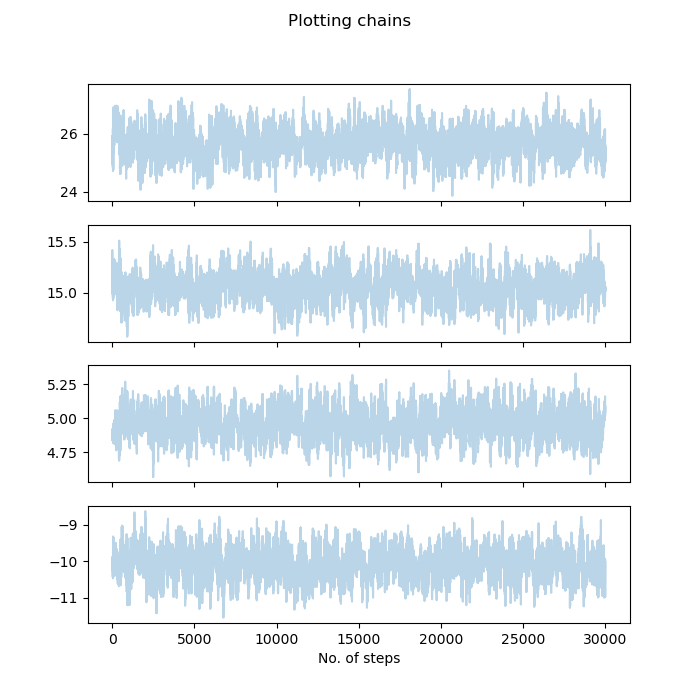

np.float64(81.59593648408091)

In [248]:
names = ['K', 'P', 't0', 'v0']
fig, axs = plt.subplots(ndim, 1, figsize = (7,7), sharex = True)

for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[::10, i], alpha = 0.3)
plt.xlabel("No. of steps")
plt.suptitle("Plotting chains")
plt.show()

auto_corr = np.median(sampler.get_autocorr_time())
auto_corr

#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

τ measures how many steps it takes to get an effectively independent sample.
If you need near‑independent draws for e.g. plotting or a small posterior set, thinning ≈ τ

In [249]:
auto_corr = np.ceil(auto_corr)
auto_corr = int(auto_corr)

In [250]:
samples_new = sampler.get_chain(thin = auto_corr, discard = 1000, flat = True)
medians = {}
sd = {}

for i, name in enumerate(names):
    medians[name] = np.median(samples_new[:, i])
    sd[name] = np.std(samples_new[:, i])



#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

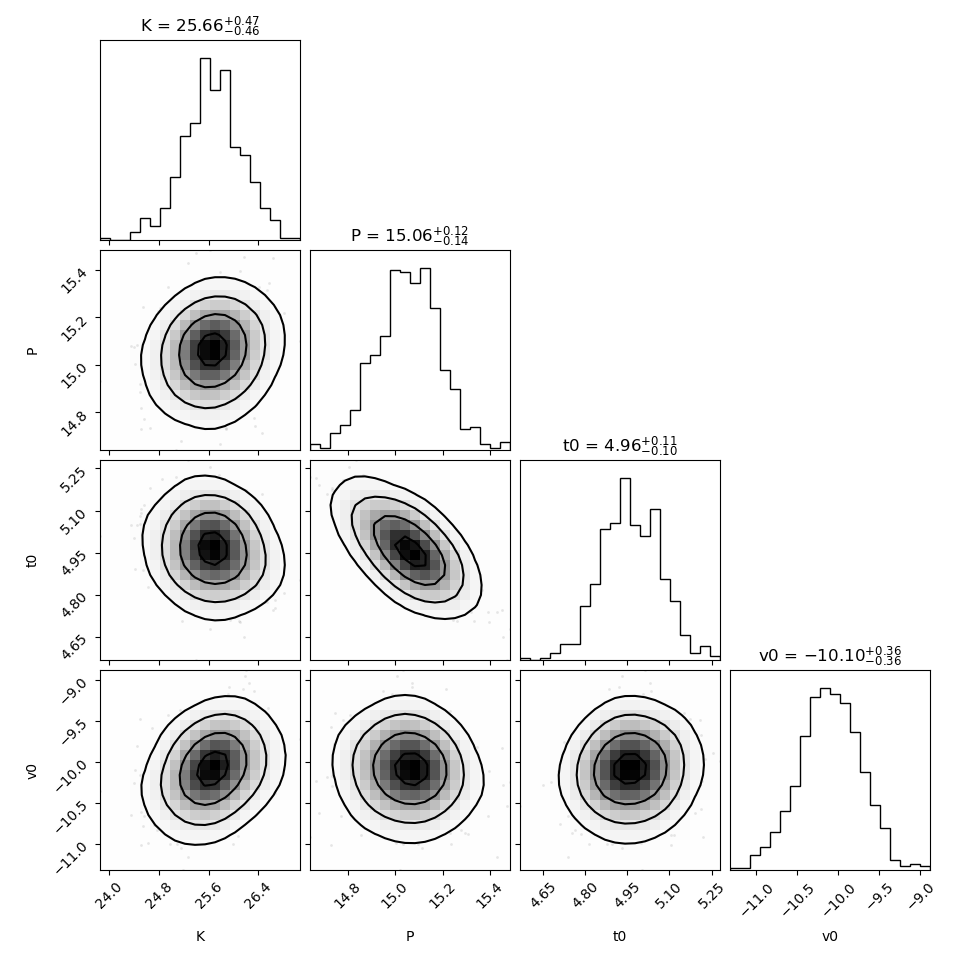

In [269]:
# you can use the corner package 
fig = corner.corner(samples_new[::5,:], plot_contours=True, show_titles=True, smooth=2, labels=names)

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

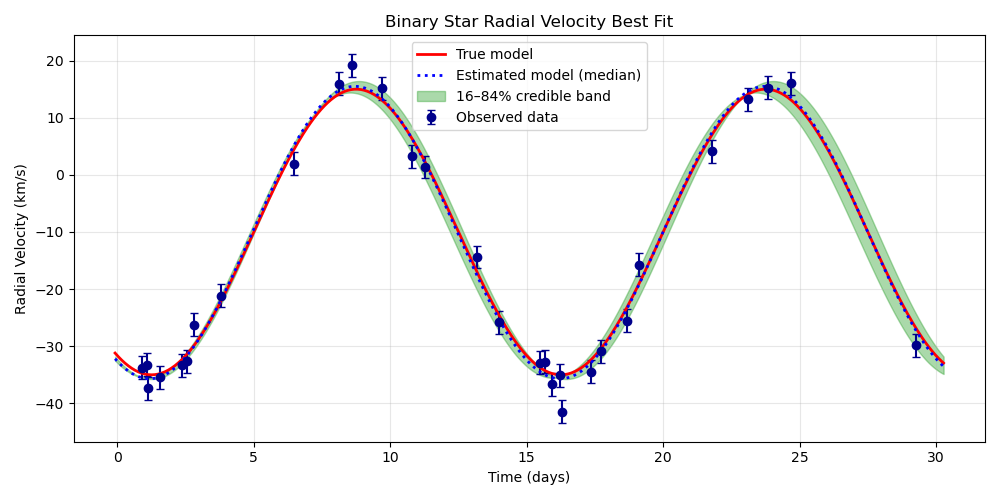

In [ ]:
p50, p16, p84 = np.percentile(samples_new, [50, 16, 84], axis=0)
medians['K'], medians['P'], medians['t0'], medians['v0'] = p50

t_plot = np.linspace(np.min(t_obs)-1, np.max(t_obs)+1, 500)
v_true_plot = radial_velocity_model(t_plot, K_true, P_true, t0_true, v0_true)
v_med_plot  = radial_velocity_model(t_plot, *p50)
v_lo = radial_velocity_model(t_plot, *p16)
v_hi = radial_velocity_model(t_plot, *p84)

plt.figure(figsize=(10,5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', color='darkblue',
             markersize=6, capsize=3, label='Observed data')
plt.plot(t_plot, v_true_plot, 'r-', lw=2, label='True model')
plt.plot(t_plot, v_med_plot, 'b:', lw=2, label='Estimated model (median)')
plt.fill_between(t_plot, v_lo, v_hi, color='C2', alpha=0.4, label='16-84 CI')

plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (km/s)')
plt.title('Binary Star Radial Velocity Best Fit')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

I see a correlation between [K ,v0] and [P, t0]. K and v0 might show correlation because K affects the height of your sin function and v0 also affects a baseline vertical shift of that function. i dont fully understand why they should show such high correlation.



**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

We are most definitely very close to our values. Actual values: [25,15,5,-10] and we recover [25.66, 15.06, 4.96, -10.10] which are super close.




**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.

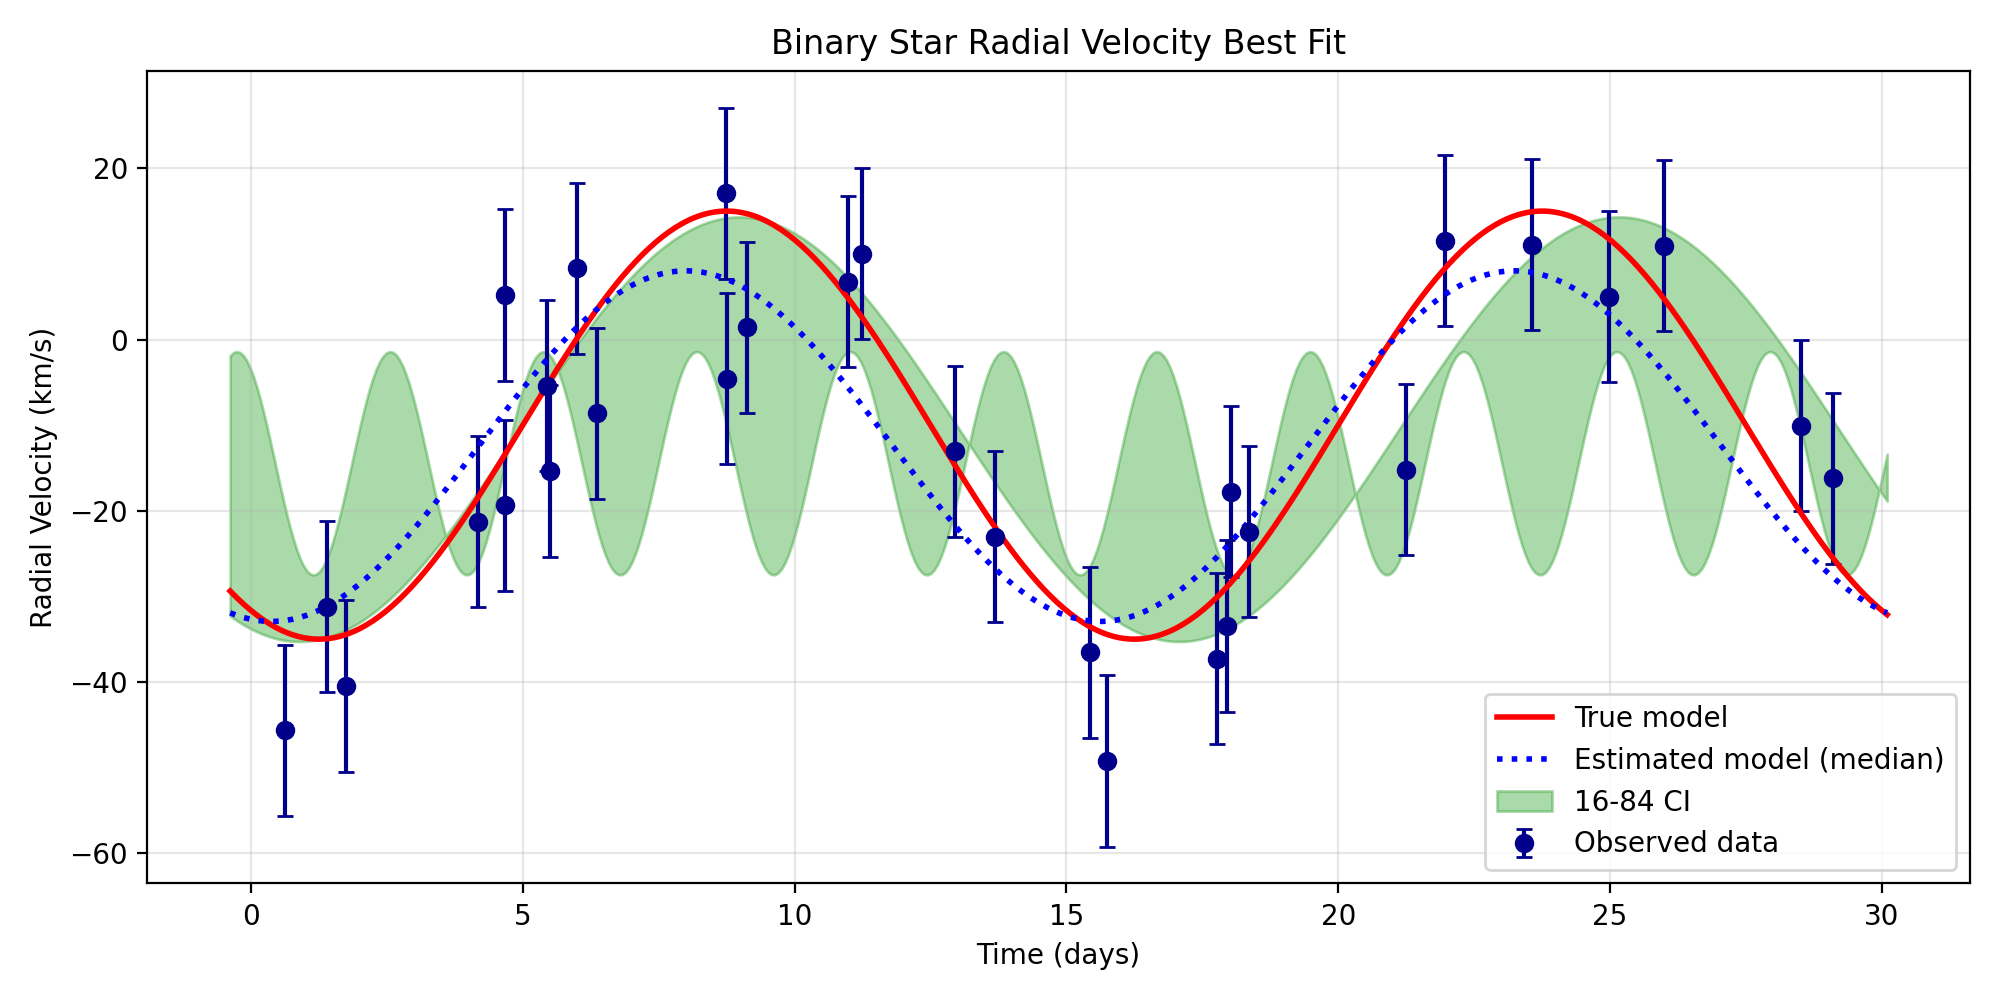

We see the image starts to go beserk. Increasing the error really messes with with our CI and causes disagreement between the true and median models.

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?

I was not able to run it with nwalkers=4 but if we decrease the nwalkers, the autocorrelation time would be insanely high and mixing also wont be that good. If we choose low nsteps i got another error:  "The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!  N/50 = 2;" so i was not able to attach graph for either of them. Using low nsteps, we risk the walkers being inside the burnin steps but even with no burn in we have no guarantee we have sampled the full parameter space and converged.
